In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 12})

import pandas as pd

import seaborn as sns

from my_functions import *
from LF_puricomp_corrections import puricomp2d_weights

import glob

from scipy.integrate import simpson
from scipy.stats import binned_statistic

from astropy.cosmology import Planck18 as cosmo
import astropy.units as u

In [ ]:
w_central = central_wavelength()
nb_fwhm_Arr = nb_fwhm(range(60))
w_lya = 1215.67

In [ ]:
## Load my QSO catalog

filename = '/home/alberto/almacen/Source_cats/QSO_100000_v7/data.csv'
data_qso = pd.read_csv(filename)

qso_flx = data_qso.to_numpy()[:, 1 : 60 + 1].T
qso_err = data_qso.to_numpy()[:, 60 + 1 : 120 + 1].T

EW_qso = data_qso['EW0'].to_numpy()
qso_zspec = data_qso['z'].to_numpy()

In [ ]:
## Load SF catalog

filename = '/home/alberto/almacen/Source_cats/LAE_10deg_z2-4_v7/'
files = glob.glob(filename +'data*')
files.sort()
fi = []

for name in files:
    fi.append(pd.read_csv(name))

data = pd.concat(fi, axis=0, ignore_index=True)

sf_flx = data.to_numpy()[:, 1 : 60 + 1].T
sf_err = data.to_numpy()[:, 60 + 1 : 120 + 1].T

EW_sf = data['EW0'].to_numpy()
sf_zspec = data['z'].to_numpy()

In [ ]:
pm_flx = np.hstack((qso_flx, sf_flx))
pm_err = np.hstack((qso_err, sf_err))
zspec = np.concatenate((qso_zspec, sf_zspec))
EW_lya = np.concatenate((EW_qso, EW_sf))

N_sf = sf_flx.shape[1]
N_qso = qso_flx.shape[1]

qso_dL = cosmo.luminosity_distance(qso_zspec).to(u.cm).value
sf_dL = cosmo.luminosity_distance(sf_zspec).to(u.cm).value

sf_L = data['L_lya'].to_numpy()
qso_L = data_qso['L_lya'].to_numpy()

sf_flambda = 10 ** sf_L / (4*np.pi * sf_dL **2)
qso_flambda = data_qso['F_line']

L_lya = np.concatenate((qso_L, sf_L))
fline = np.concatenate((qso_flambda, sf_flambda))

is_qso = np.concatenate((np.ones(N_qso), np.zeros(N_sf))).astype(bool)

N_sources = pm_flx.shape[1]

%xdel sf_flx
%xdel sf_err
%xdel qso_flx
%xdel qso_err
%xdel sf_zspec
%xdel qso_zspec
%xdel EW_sf
%xdel EW_qso
%xdel qso_dL
%xdel sf_L
%xdel qso_L
%xdel sf_flambda
%xdel qso_flambda
%xdel mock
%xdel data
%xdel data_qso

NameError: name 'mock' is not defined


In [ ]:
N_sources = pm_flx.shape[1]
N_sources

418945

In [ ]:
mag = flux_to_mag(pm_flx[-2], w_central[-2])
mag[np.isnan(mag)] = 99.

/home/alberto/cosmos/LAEs/my_functions.py:20: RuntimeWarning: invalid value encountered in log10
  return -2.5 * np.log10(f * w**2/c * 1e-8) - 48.60


In [ ]:
# Lya search
cont_est_lya, cont_err_lya = estimate_continuum(pm_flx, pm_err, IGM_T_correct=True)
line = is_there_line(pm_flx, pm_err, cont_est_lya, cont_err_lya, 20)
lya_lines, lya_cont_lines, line_widths = identify_lines(
    line, pm_flx, pm_err, first=True, return_line_width=True
)
lya_lines = np.array(lya_lines)

# Other lines
cont_est_other, cont_err_other = estimate_continuum(pm_flx, pm_err, IGM_T_correct=False)
line_other = is_there_line(pm_flx, pm_err, cont_est_other, cont_err_other,
    400, obs=True)
other_lines = identify_lines(line_other, pm_flx, pm_err)

# Compute z
z_Arr = np.zeros(N_sources)
z_Arr[np.where(np.array(lya_lines) != -1)] =\
    z_NB(np.array(lya_cont_lines)[np.where(np.array(lya_lines) != -1)])

nice_z = np.abs(z_Arr - zspec) < 0.12

%xdel cont_est_other
%xdel cont_err_other

In [ ]:
mag_min = 16
mag_max = 23.5

nb_min = 3
nb_max = 15

# Used later!!
L_min = 43.7
L_max = 50

nbs_to_consider = np.arange(nb_min, nb_max + 1)

nb_cut = (np.array(lya_lines) >= nb_min) & (np.array(lya_lines) <= nb_max)

z_min = (w_central[nb_min] - nb_fwhm_Arr[nb_min] * 0.5) / w_lya - 1
z_max = (w_central[nb_max] + nb_fwhm_Arr[nb_max] * 0.5) / w_lya - 1

z_cut = (z_min < z_Arr) & (z_Arr < z_max)
zspec_cut = (z_min < zspec) & (zspec < z_max)
ew_cut = EW_lya > 20
mag_cut = (mag > mag_min) & (mag < mag_max)

nice_lya = nice_lya_select(
    lya_lines, other_lines, pm_flx, pm_err, cont_est_lya, z_Arr
)
nice_lya = (nice_lya & z_cut & mag_cut)

/home/alberto/cosmos/LAEs/my_functions.py:495: RuntimeWarning: divide by zero encountered in double_scalars
  lya_L_err[src] = np.sum(pm_err[l - 7 : l - 1, src] ** -2) ** -0.5
/home/alberto/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alberto/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/alberto/cosmos/LAEs/my_functions.py:504: RuntimeWarning: divide by zero encountered in double_scalars
  lya_R2_err[src] = np.sum(pm_err[l + 12 : l + 12 + 5, src] ** -2) ** -0.5


In [ ]:
EW_nb_Arr, EW_nb_e, L_Arr, L_e_Arr, flambda, flambda_e = EW_L_NB(
    pm_flx, pm_err, cont_est_lya, cont_err_lya, z_Arr, lya_lines, N_nb=0
)

# Bias in flambda in each NB
def compute_corrections(flambda, fline):
    F_cor = np.ones(60)

    for nb in nbs_to_consider:
        to_cor = nice_z & (lya_lines == nb) & mag_cut
        F_to_cor = (flambda / fline)[to_cor]
        F_to_cor[np.isinf(F_to_cor)] = np.nan
        F_cor[nb] = np.nanmedian(F_to_cor)

    return F_cor

F_cor = compute_corrections(flambda, fline)

np.save('npy/F_cor.npy', F_cor)

EW_nb_Arr, EW_nb_e, L_Arr, L_e_Arr, flambda, flambda_e = EW_L_NB(
    pm_flx, pm_err, cont_est_lya, cont_err_lya, z_Arr, lya_lines, N_nb=0, F_bias=F_cor
)

nice_lya = nice_lya & (L_Arr > L_min) & (L_Arr < L_max)

/home/alberto/cosmos/LAEs/my_functions.py:612: RuntimeWarning: invalid value encountered in true_divide
  EW_nb_Arr = flambda / cont / (1 + z_Arr)
/home/alberto/cosmos/LAEs/my_functions.py:613: RuntimeWarning: invalid value encountered in true_divide
  EW_nb_e = flambda_e / cont / (1 + z_Arr)
/home/alberto/cosmos/LAEs/my_functions.py:631: RuntimeWarning: divide by zero encountered in log10
  L_Arr = np.log10(flambda * 4*np.pi * dL ** 2)


In [ ]:
def compute_L_Lbin_err(L_Arr, L_lya, L_binning):
    '''
    Computes the errors due to dispersion of L_retrieved with some L_retrieved binning
    '''
    L_Lbin_err_plus = np.ones(len(L_binning) - 1) * 99
    L_Lbin_err_minus = np.ones(len(L_binning) - 1) * 99
    median = np.ones(len(L_binning) - 1) * 99
    last = [99., 99.]
    for i in range(len(L_binning) - 1):
        in_bin = (10 ** L_Arr >= L_binning[i]) & (10 ** L_Arr < L_binning[i + 1])
        if count_true(in_bin) == 0:
            L_Lbin_err_plus[i] = last[0]
            L_Lbin_err_minus[i] = last[1]
            continue
        perc = np.nanpercentile((10 ** L_Arr - 10 ** L_lya)[in_bin], [16, 50, 84])
        L_Lbin_err_plus[i] = perc[2] - perc[1]
        
        last = [L_Lbin_err_plus[i], L_Lbin_err_minus[i]]
        median[i] = perc[1]

    return L_Lbin_err_plus, median

L_binning = np.logspace(42, 46, 15 + 1)
L_Lbin_err, median_L = compute_L_Lbin_err(L_Arr[nice_z], L_lya[nice_z], L_binning)
np.save('npy/L_nb_err.npy', L_Lbin_err)
np.save('npy/L_bias.npy', median_L)
np.save('npy/L_nb_err_binning.npy', L_binning)

In [ ]:
# Apply bin err
L_binning_position = binned_statistic(
        10 ** L_Arr, None, 'count', bins=L_binning
).binnumber
L_binning_position[L_binning_position > len(L_binning) - 2] = len(L_binning) - 2
L_e_Arr = L_Lbin_err[L_binning_position]

In [ ]:
%xdel pm_flx
%xdel pm_err
%xdel cont_est_lya
%xdel cont_err_lya

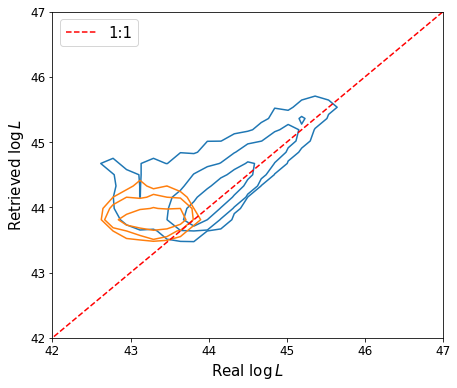

In [ ]:
fig, ax = plt.subplots(figsize=(7, 6))

mask = ((mag[is_qso] < 23) & nice_lya[is_qso] & nice_z[is_qso])
Z, x, y = np.histogram2d(
    L_lya[is_qso][mask], L_Arr[is_qso][mask],
    bins=(np.linspace(42, 47, 30), np.linspace(42, 47, 30))
)

H_min = np.amin(Z)
H_max = np.amax(Z)

y_centers = 0.5 * ( y[1:] + y[:-1] )
x_centers = 0.5 * ( x[1:] + x[:-1] )

N_bins = 10000

H_Arr = np.linspace( H_min , H_max , N_bins )[::-1]

fact_up_Arr = np.zeros( N_bins )

TOTAL_H = np.sum(Z)

for iii in range(0, N_bins):

    mask = Z > H_Arr[iii]

    fact_up_Arr[iii] = np.sum(Z[ mask ]) / TOTAL_H

H_value_68 = np.interp(0.683, fact_up_Arr, H_Arr) # 1sigma
H_value_95 = np.interp(0.954, fact_up_Arr, H_Arr) # 2sigma
H_value_99 = np.interp(0.997, fact_up_Arr, H_Arr) # 2sigma

ax.contour(
    x_centers, y_centers, Z.T, levels=[H_value_99, H_value_95, H_value_68],
    colors='C0'
)

mask = (~is_qso & (mag < 23) & nice_lya & nice_z)
Z, x, y = np.histogram2d(
    L_lya[mask], L_Arr[mask],
    bins=(np.linspace(42, 47, 30), np.linspace(42, 47, 30))
)

H_min = np.amin(Z)
H_max = np.amax(Z)

y_centers = 0.5 * ( y[1:] + y[:-1] )
x_centers = 0.5 * ( x[1:] + x[:-1] )

N_bins = 10000

H_Arr = np.linspace(H_min , H_max , N_bins )[::-1]

fact_up_Arr = np.zeros(N_bins)

TOTAL_H = np.sum(Z)

for iii in range(0, N_bins):

    mask = Z > H_Arr[iii]

    fact_up_Arr[iii] = np.sum(Z[ mask ]) / TOTAL_H

H_value_68 = np.interp(0.683, fact_up_Arr, H_Arr) # 1sigma
H_value_95 = np.interp(0.954, fact_up_Arr, H_Arr) # 2sigma
H_value_99 = np.interp(0.997, fact_up_Arr, H_Arr) # 2sigma

ax.contour(
    x_centers, y_centers, Z.T, levels=[H_value_99, H_value_95, H_value_68],
    colors='C1'
)

# ax.clabel(CS, inline=1, fontsize=10)

# ax.scatter(L_lya[nice_lya & is_qso], L_Arr[nice_lya & is_qso],
#     label='QSO', alpha=0.3)
# ax.scatter(L_lya[nice_lya & ~is_qso], L_Arr[nice_lya & ~is_qso],
#     label='SF', alpha=0.3)

x = np.linspace(40, 48, 100)
ax.plot(x, x, linestyle='--', color='red', label='1:1')

# Lx = [(L_binning[i] + L_binning[i + 1]) / 2 for i in range(len(L_binning) - 1)]
# ax.plot(Lx, Lx + median_L, c='k')
# ax.plot(Lx, Lx + median_L - L_Lbin_err[1], c='gray')
# ax.plot(Lx, Lx + median_L + L_Lbin_err[0], c='gray')

ax.set_ylabel('Retrieved $\log L$', fontsize=15)
ax.set_xlabel('Real $\log L$', fontsize=15)

ax.set_ylim((42, 47))
ax.set_xlim((42, 47))

ax.legend(fontsize=15)

plt.show()

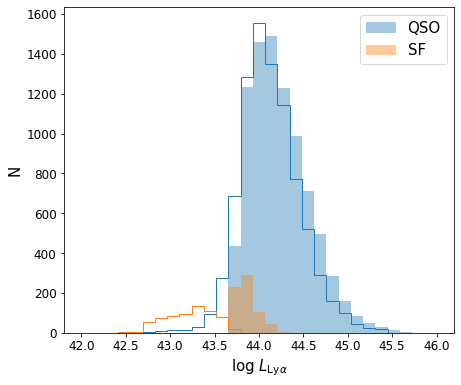

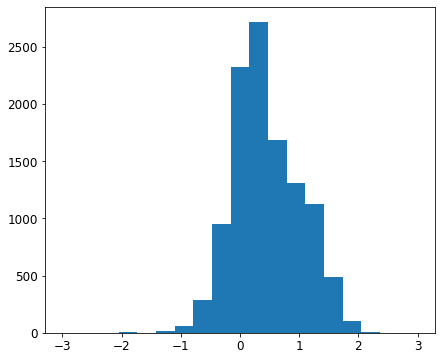

In [ ]:
fig, ax = plt.subplots(figsize=(7, 6))

mask = (nice_lya & nice_z & (mag < mag_max) & is_qso)
ax.hist(L_Arr[mask], bins=np.linspace(42, 46, 30), color='C0', alpha=0.4, label='QSO')

mask = (nice_lya & nice_z & (mag < mag_max) & ~is_qso)
ax.hist(L_Arr[mask], bins=np.linspace(42, 46, 30), color='C1', alpha=0.4, label='SF')

mask = (nice_lya & nice_z & (mag < mag_max) & is_qso)
ax.hist(L_lya[mask], bins=np.linspace(42, 46, 30), color='C0', histtype='step')

mask = (nice_lya & nice_z & (mag < mag_max) & ~is_qso)
ax.hist(L_lya[mask], bins=np.linspace(42, 46, 30), color='C1', histtype='step')

ax.legend(fontsize=15)

ax.set_xlabel(r'log $L_{\mathrm{Ly}\alpha}$', fontsize=15)
ax.set_ylabel('N', fontsize=15)

plt.show()

# Err test

fig, ax = plt.subplots(figsize=(7, 6))

ax.hist(
    (10 ** L_Arr[nice_lya] - 10 ** L_lya[nice_lya]) / L_e_Arr[nice_lya],
    bins=np.linspace(-3, 3, 20)
)

plt.show()

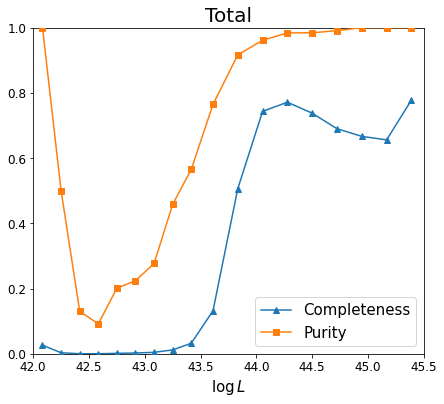

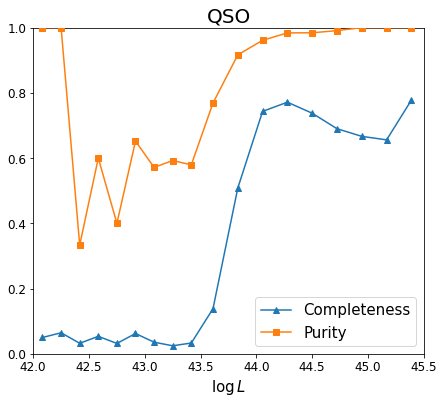

/tmp/ipykernel_572790/976516170.py:74: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(b_c, hg / totals, marker='^', label='Completeness', zorder=99)
/tmp/ipykernel_572790/976516170.py:75: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(b_c, hg / (hg + hb), marker='s', label='Purity', zorder=99)


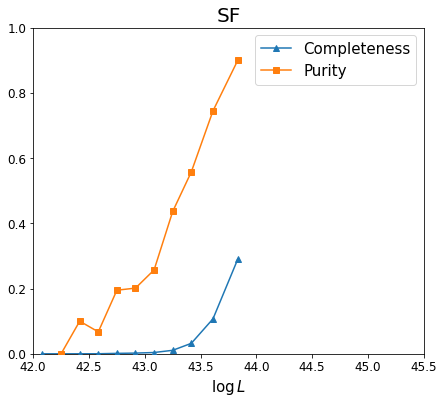

In [ ]:
N_bins_1 = 9
N_bins_2 = 9
bins = np.concatenate((
    np.linspace(42, 43.5, N_bins_1 + 1),
    np.linspace(43.5, 45.5, N_bins_2 + 1)[1:]
))
bin_centers = [(bins[k] + bins[k + 1]) / 2 for k in range(len(bins) - 1)]

phistar1 = 3.33e-6
Lstar1 = 10 ** 44.65
alpha1 = -1.35
phistar2 = 10 ** -3.45
Lstar2 = 10 ** 42.93
alpha2 = -1.93

volume = z_volume(z_min, z_max, 200)

bins2 = np.linspace(42, 46, 30)
h_qso, _ = np.histogram(L_lya[is_qso & zspec_cut & ew_cut & mag_cut], bins2)
h_sf, _ = np.histogram(L_lya[~is_qso & zspec_cut & ew_cut & mag_cut], bins2)

b_c = [0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins) - 1)]
bw = [bins[i + 1] - bins[i] for i in range(len(bins) - 1)]
###################################################

fig, ax = plt.subplots(figsize=(7, 6))

goodh = L_lya[nice_lya & nice_z]
badh = L_lya[nice_lya & ~nice_z]
hg, bg = np.histogram(goodh, bins=bins)
hb, _ = np.histogram(badh, bins=bins)
totals, _ = np.histogram(L_lya[zspec_cut], bins=bins)

ax.plot(b_c, hg / totals, marker='^', label='Completeness', zorder=99)
ax.plot(b_c, hg / (hg + hb), marker='s', label='Purity', zorder=99)

ax.set_xlabel('$\log L$', fontsize=15)

ax.set_xlim((42, 45.5))
ax.set_ylim((0, 1))
ax.legend(fontsize=15)
ax.set_title('Total', fontsize=20)

plt.show()

fig, ax = plt.subplots(figsize=(7, 6))

goodh = L_lya[nice_lya & nice_z & is_qso]
badh = L_lya[nice_lya & ~nice_z & is_qso]
hg, bg = np.histogram(goodh, bins=bins)
hb, _ = np.histogram(badh, bins=bins)
totals, _ = np.histogram(L_lya[zspec_cut & is_qso], bins=bins)

ax.plot(b_c, hg / totals, marker='^', label='Completeness', zorder=99)
ax.plot(b_c, hg / (hg + hb), marker='s', label='Purity', zorder=99)

ax.set_xlabel('$\log L$', fontsize=15)

ax.set_xlim((42, 45.5))
ax.set_ylim((0, 1))
ax.legend(fontsize=15)
ax.set_title('QSO', fontsize=20)

plt.show()

fig, ax = plt.subplots(figsize=(7, 6))

goodh = L_lya[nice_lya & nice_z & ~is_qso]
badh = L_lya[nice_lya & ~nice_z & ~is_qso]
hg, bg = np.histogram(goodh, bins=bins)
hb, _ = np.histogram(badh, bins=bins)
totals, _ = np.histogram(L_lya[zspec_cut & ~is_qso], bins=bins)

ax.plot(b_c, hg / totals, marker='^', label='Completeness', zorder=99)
ax.plot(b_c, hg / (hg + hb), marker='s', label='Purity', zorder=99)

ax.set_xlabel('$\log L$', fontsize=15)

ax.set_xlim((42, 45.5))
ax.set_ylim((0, 1))
ax.legend(fontsize=15)
ax.set_title('SF', fontsize=20)

plt.show()

/tmp/ipykernel_572790/1783918316.py:35: RuntimeWarning: invalid value encountered in log10
  L_perturbed = np.log10(
/tmp/ipykernel_572790/1783918316.py:83: RuntimeWarning: invalid value encountered in true_divide
  puri2d = h2d_nice / h2d_sel
/tmp/ipykernel_572790/1783918316.py:84: RuntimeWarning: divide by zero encountered in true_divide
  comp2d = h2d_nice / h2d_parent
/tmp/ipykernel_572790/1783918316.py:84: RuntimeWarning: invalid value encountered in true_divide
  comp2d = h2d_nice / h2d_parent
/tmp/ipykernel_572790/1783918316.py:86: RuntimeWarning: divide by zero encountered in true_divide
  comp1d = h1d_nice / h1d_parent


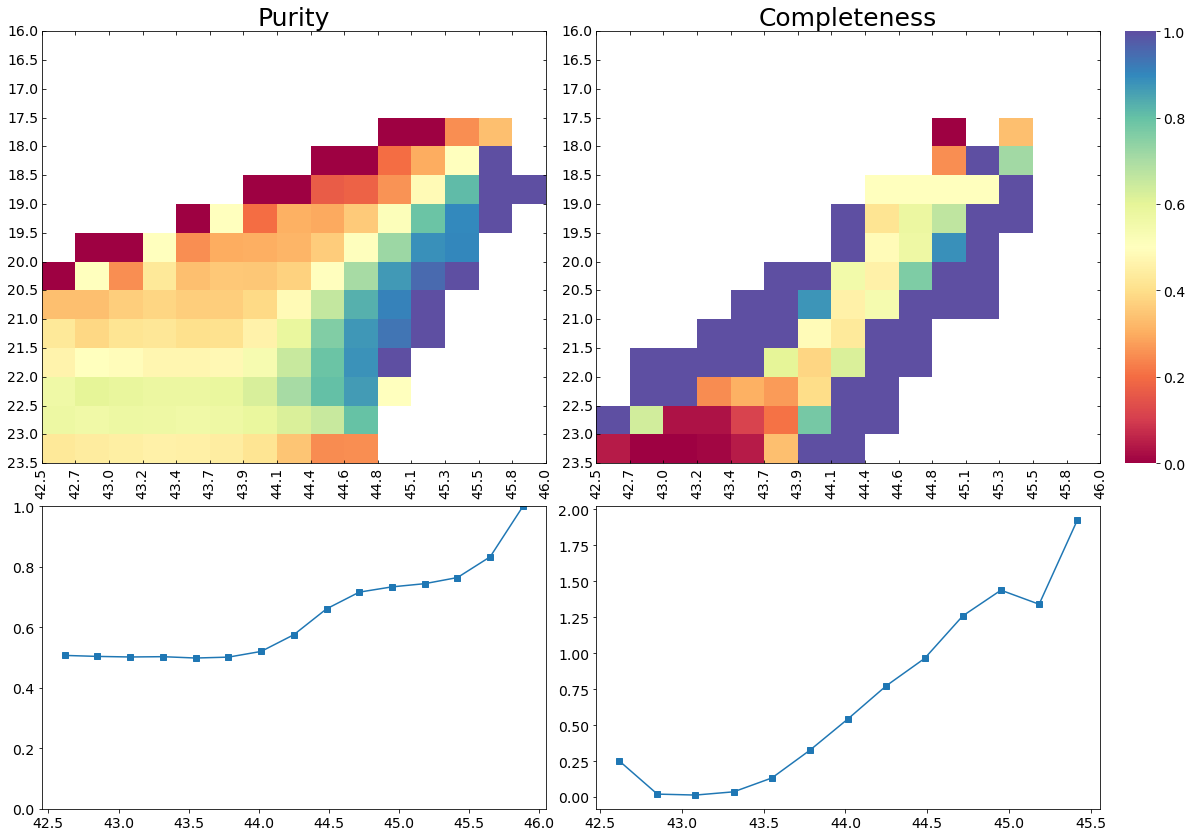

In [ ]:
def make_2d_puricomp(L_Arr, L_lya, mag, L_bins):
    fig = plt.figure(figsize=(7, 6))

    height = 1.
    width = 1.
    height2 = 0.7
    spacing = 0.1
    cbar_width = 0.06

    ax0 = fig.add_axes([0, height2 + spacing, width, height])
    ax1 = fig.add_axes([width + spacing, height2 + spacing, width, height])
    axc = fig.add_axes([2 * width + 1.5 * spacing, height2 + spacing, cbar_width, height])
    ax2 = fig.add_axes([0, 0, width, height2])
    ax3 = fig.add_axes([width + spacing, 0, width, height2])

    L_bins = np.linspace(42.5, 46, 15 + 1)
    r_bins = np.linspace(mag_min, mag_max, 15 + 1)

    L_bins_c = np.array([0.5 * (L_bins[i] + L_bins[i + 1]) for i in range(len(L_bins) - 1)])

    # Perturb L
    
    N_iter = 1000
    h2d_nice_i = np.empty((len(L_bins) - 1, len(r_bins) - 1, N_iter))
    h2d_sel_i = np.empty((len(L_bins) - 1, len(r_bins) - 1, N_iter))
    h1d_nice_i = np.empty((len(L_bins) - 1, N_iter))
    h1d_sel_i = np.empty((len(L_bins) - 1, N_iter))

    # L_binning_position = binned_statistic(
    #     L_Arr, None, 'count', bins=L_binning
    # ).binnumber
    # L_binning_position[L_binning_position > len(L_binning) - 2] = len(L_binning) - 2

    for k in range(N_iter):
        L_perturbed = np.log10(
            10 ** L_Arr + L_e_Arr * np.random.randn(len(L_e_Arr))
        )
        L_perturbed[np.isnan(L_perturbed)] = 0.

        h2d_nice_i[..., k], _, _ = np.histogram2d(
            L_perturbed[nice_lya & nice_z],
            mag[nice_lya & nice_z],
            bins=[L_bins, r_bins]
        )

        h2d_sel_i[..., k], _, _ = np.histogram2d(
            L_perturbed[nice_lya],
            mag[nice_lya],
            bins=[L_bins, r_bins]
        )

        h1d_nice_i[..., k], _ = np.histogram(L_perturbed[nice_lya & nice_z], bins=L_bins)
        h1d_sel_i[..., k], _ = np.histogram(L_perturbed[nice_lya], bins=L_bins)

    # Take the median
    h2d_nice = np.median(h2d_nice_i, axis=2)
    h2d_sel = np.median(h2d_sel_i, axis=2)
    h1d_nice = np.median(h1d_nice_i, axis=1)
    h1d_sel = np.median(h1d_sel_i, axis=1)

    # h2d_nice, _, _ = np.histogram2d(
    #     L_Arr[nice_lya & nice_z],
    #     mag[nice_lya & nice_z],
    #     bins=[L_bins, r_bins]
    # )
    # h2d_sel, _, _ = np.histogram2d(
    #     L_Arr[nice_lya],
    #     mag[nice_lya],
    #     bins=[L_bins, r_bins]
    # )

    h2d_parent, _, _ = np.histogram2d(
        L_lya[zspec_cut & mag_cut & ew_cut],
        mag[zspec_cut & mag_cut & ew_cut],
        bins=[L_bins, r_bins]
    )
    h1d_parent, _ = np.histogram(L_lya[zspec_cut & mag_cut & ew_cut], bins=L_bins)
    # h1d_nice, _ = np.histogram(L_Arr[nice_lya & nice_z], bins=L_bins)
    # h1d_sel, _ = np.histogram(L_Arr[nice_lya], bins=L_bins)

    cmap = 'Spectral'

    puri2d = h2d_nice / h2d_sel
    comp2d = h2d_nice / h2d_parent
    puri1d = h1d_nice / h1d_sel
    comp1d = h1d_nice / h1d_parent

    puri1d[np.isnan(puri1d)] = 0.
    comp1d[np.isnan(comp1d)] = 0.

    ### PLOT STUFF

    sns.heatmap(puri2d.T, ax=ax0, vmin=0, vmax=1, cbar_ax=axc, cmap=cmap)
    sns.heatmap(comp2d.T, ax=ax1, vmin=0, vmax=1, cbar=False, cmap=cmap)

    ax2.plot(L_bins_c, puri1d, marker='s')
    ax3.plot(L_bins_c, comp1d, marker='s')

    ### TICKS

    xticks = range(len(L_bins))
    yticks = range(len(r_bins))
    xtick_labels = ['{0:0.1f}'.format(n) for n in L_bins]
    ytick_labels = ['{0:0.1f}'.format(n) for n in r_bins]


    ax0.set_yticks(yticks)
    ax0.set_yticklabels(ytick_labels, rotation='horizontal')
    ax0.set_xticks(xticks)
    ax0.set_xticklabels(xtick_labels, rotation='vertical')
    ax0.yaxis.set_ticks_position('both')
    ax0.xaxis.set_ticks_position('both')
    ax0.tick_params(axis='y', direction='in', labelsize=14)
    ax0.tick_params(axis='x', direction='in', labelsize=14)

    ax1.set_yticks(yticks)
    ax1.set_yticklabels(ytick_labels, rotation='horizontal')
    ax1.set_xticks(xticks)
    ax1.set_xticklabels(xtick_labels, rotation='vertical')
    ax1.yaxis.set_ticks_position('both')
    ax1.xaxis.set_ticks_position('both')
    ax1.tick_params(axis='y', direction='in', labelsize=14)
    ax1.tick_params(axis='x', direction='in', labelsize=14)

    axc.tick_params(labelsize=14)
    ax2.tick_params(labelsize=14)
    ax3.tick_params(labelsize=14)

    ## Spines
    ax0.spines[:].set_visible(True)
    ax1.spines[:].set_visible(True)

    ## Axes labels
    # ax0.set_ylabel('rSDSS')
    # ax0.set_xlabel('log L$_\mathrm{Lya}$')
    # ax1.set_ylabel('rSDSS')
    # ax1.set_xlabel('log L$_\mathrm{Lya}$')

    ## Axis lims
    ax2.set_ylim((0, 1))
    # ax3.set_ylim((0, 1))

    ## Titles
    ax0.set_title('Purity', fontsize=25)
    ax1.set_title('Completeness', fontsize=25)

    plt.show()

    np.save('npy/puri2d.npy', puri2d)
    np.save('npy/comp2d.npy', comp2d)
    np.save('npy/puricomp2d_L_bins.npy', L_bins)
    np.save('npy/puricomp2d_r_bins.npy', r_bins)

    return puri2d, comp2d, L_bins, r_bins
puri2d, comp2d, L_bins, r_bins = make_2d_puricomp(L_Arr, L_lya, mag, bins)

In [ ]:
def Lya_intrisic_completeness(L, z, starprob=None):
    if starprob == None:
        starprob = np.zeros(L.shape)

    isstar = (starprob >= 0.5)

    ## MiniJPAS limiting r magnitudes
    mag = np.ones(L.shape) * 23.6
    mag[~isstar] = 22.7

    Fline = 10 ** L / (cosmo.luminosity_distance(z).to(u.cm).value ** 2 * 4*np.pi)
    fcont = mag_to_flux(mag, 6750)

    EW_max = Fline / fcont / (1 + z)

    ew_x = np.linspace(20, 1000, 10000)
    w_0 = 75
    ew_dist = lambda ew_xx: np.exp(-ew_xx / w_0)

    total_ew = simpson(ew_dist(ew_x), ew_x)

    completeness = np.empty(L.shape)

    for src in range(len(L)):
        src_ew_x = np.linspace(20, EW_max[src], 1000)
        completeness[src] = simpson(ew_dist(src_ew_x), src_ew_x) / total_ew

    return completeness

In [ ]:
intcomp = Lya_intrisic_completeness(L_Arr[nice_lya], z_Arr[nice_lya], None)

In [ ]:
# Selection algorithm weights
# weights = puricomp2d_weights(L_Arr[nice_lya], mag[nice_lya], puri2d, comp2d, L_bins, r_bins)

In [ ]:
def LF_perturb_err(L_Arr, L_e_Arr, nice_lya, bins, weights=True):
    N_bins = len(bins) - 1

    hist_i_mat = np.zeros((1000, N_bins))

    for k in range(1000):
        # randN = np.random.randn(N_sources)
        # L_perturbation = np.zeros(N_sources)
        # L_perturbation[randN >= 0.] = L_err[0, randN >= 0.] * randN[randN >= 0.]
        # L_perturbation[randN < 0.] = L_err[1, randN < 0.] * randN[randN < 0.]

        # L_perturbed = np.log10(10 ** (L_Arr - L_bias) + L_perturbation)
        L_perturbed = np.log10(
            10 ** L_Arr + L_e_Arr * np.random.randn(len(L_e_Arr))
        )
        L_perturbed[np.isnan(L_perturbed)] = 0.

        w = puricomp2d_weights(
            L_perturbed[nice_lya], mag[nice_lya], puri2d, comp2d, L_bins, r_bins
        )
        if not weights:
            w[:] = 1
        hist = np.histogram(L_perturbed[nice_lya], bins=bins)[0]
        hist_poiss_err = np.round(
            hist[0] ** 0.5 * np.random.randn(len(bins) - 1), 0
        ).astype(int)

        hist_binnumber = binned_statistic(L_perturbed[nice_lya], None, 'count', bins=bins)[2]

        L_Arr_to_hist = np.array([])
        w_Arr_to_hist = np.array([])
        for bin in range(N_bins):
            where_bin = np.where(hist_binnumber == bin + 1)[0]
            try:
                idx = np.random.choice(
                    where_bin, size=(hist_poiss_err[bin] + hist[bin]),
                    replace=True
                )
                L_Arr_to_hist = np.hstack([L_Arr_to_hist, L_perturbed[nice_lya][idx]])
                w_Arr_to_hist = np.hstack([w_Arr_to_hist, w[idx]])
            except:
                pass
        hist_i_mat[k], _ = np.histogram(L_Arr_to_hist, bins=bins, weights=w_Arr_to_hist)

    L_LF_err_percentiles = np.percentile(hist_i_mat, [16, 50, 84], axis=0)
    return L_LF_err_percentiles

L_LF_err_percentiles = LF_perturb_err(L_Arr, L_e_Arr, nice_lya, bins)
L_LF_err_plus = L_LF_err_percentiles[2] - L_LF_err_percentiles[1]
L_LF_err_minus = L_LF_err_percentiles[1] - L_LF_err_percentiles[0]
hist_median = L_LF_err_percentiles[1]


L_LF_err_percentiles = LF_perturb_err(L_Arr, L_e_Arr, nice_lya, bins, False)
total_hist = L_LF_err_percentiles[1]

/tmp/ipykernel_572790/3963625738.py:13: RuntimeWarning: invalid value encountered in log10
  L_perturbed = np.log10(
/home/alberto/cosmos/LAEs/LF_puricomp_corrections.py:48: RuntimeWarning: invalid value encountered in true_divide
  w_mat = puri2d / comp2d


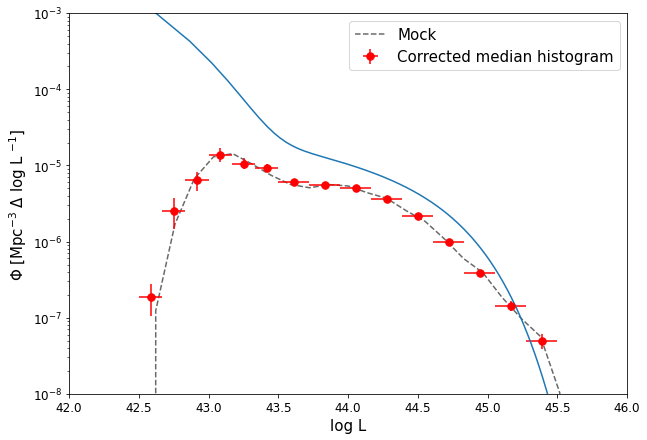

In [ ]:
LF_bins = np.array([(bins[i] + bins[i + 1]) / 2 for i in range(len(bins) - 1)])

bin_width = np.array([bins[i + 1] - bins[i] for i in range(len(bins) - 1)])

volume = z_volume(z_min, z_max, 200)

yerr_cor_plus = (hist_median + L_LF_err_plus ** 2) ** 0.5\
     / volume / bin_width
yerr_cor_minus = (hist_median + L_LF_err_minus ** 2) ** 0.5\
     / volume / bin_width

fig, ax = plt.subplots(figsize=(10, 7))

yerr_cor_plus = (hist_median + L_LF_err_plus ** 2) ** 0.5\
     / volume / bin_width
yerr_cor_minus = (hist_median + L_LF_err_minus ** 2) ** 0.5\
     / volume / bin_width
xerr = bin_width / 2
ax.errorbar(LF_bins, hist_median / volume / bin_width,
    yerr= [yerr_cor_minus, yerr_cor_plus], xerr=xerr,
    marker='.', linestyle='', markersize=15, c='red',
    label='Corrected median histogram')

bins2 = np.linspace(42, 46, 30)
b_c = [(bins2[i] + bins2[i + 1]) * 0.5 for i in range(len(bins2) - 1)]
bw = bins2[1] - bins2[0]
h_qso, b = np.histogram(L_lya[is_qso & zspec_cut & ew_cut & mag_cut], bins2)
h_sf, b = np.histogram(L_lya[~is_qso & zspec_cut & ew_cut & mag_cut], bins2)

ax.plot(b_c, (h_qso + h_sf) / bw / volume, c='dimgray', zorder=-99, label='Mock', ls='--')

Lx = np.linspace(10 ** 42, 10 ** 45.5, 1000)
Phi = double_schechter(
                Lx, phistar2, Lstar2, alpha2, phistar1, Lstar1, alpha1
            ) * Lx * np.log(10)

ax.plot(np.log10(Lx), Phi)

ax.set_ylim(1e-8, 1e-3)
ax.set_xlim(42., 46)
ax.set_yscale('log')

ax.legend(fontsize=15)

ax.set_xlabel('log L', fontsize=15)
ax.set_ylabel('$\Phi$ [Mpc$^{-3}$ $\Delta$ log L $^{-1}$]', fontsize=15)

plt.show()